In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import re
import seaborn as sns
from utils import pad_images
from model import RegressionModel
sns.set_palette('colorblind')
sns.set_style('darkgrid')
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # If using GPU
torch.backends.cudnn.benchmark = False    # If using GPU


# Read and Preprocess images

In [3]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 4192.58it/s]


In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [ ]:
import optuna

# Define a function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, lr, batch_size, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}: Val Loss = {val_loss:.4f}, Accuracy = {accuracy:.4f}")

    return accuracy

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Create the data loaders (replace with your own data)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create and train the model
    model = MyModel(input_size, output_size)
    accuracy = train_and_evaluate(model, train_loader, val_loader, lr, batch_size, epochs=5)
    
    return accuracy

if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


In [18]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
#create cross validation with k-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
skf.get_n_splits(X, y)
model = RegressionModel().to(device)
lr = 1e-3
epochs = 10

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=y_test.shape[0], shuffle=True)
    del X_train, X_test, y_train, y_test, train_data, test_data
    torch.cuda.empty_cache()

    train (model, train_loader, lr, epochs)
    rmse = evaluate(model, test_data)

0
73042.65625
0
76051.2109375
0
52563.7734375
0
101990.3671875


KeyboardInterrupt: 

In [17]:
def train(model, train_loader, lr, epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #train_losses = []
    for epoch in (range(epochs)):
        for images, targets in train_loader:
            model.train()
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), targets.float()) 
            loss.backward()
            optimizer.step()
            print (epoch)
            print (loss.item())
    
    return model




In [25]:
for i in train_loader:
    print (i[0].shape)

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size

In [38]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


# Model Construction

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from model import RegressionModel

# Create the regression model with ResNet as the backbone
regression_model = RegressionModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.001)

# Training loop
num_epochs =75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
train_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    val_loss = []

    for images, targets in train_loader:
        regression_model.train()
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = regression_model(images)
        loss = criterion(outputs.squeeze(), targets.float()) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #validate
        regression_model.eval()
        total_val_loss = 0
    train_loss.append(total_loss / len(train_loader))

    


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss/len(val_loader)}")


/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  1%|▏         | 1/75 [00:06<08:12,  6.66s/it]

Epoch 1/75, Loss: 59890.78575721154


  3%|▎         | 2/75 [00:13<08:05,  6.65s/it]

Epoch 2/75, Loss: 11926.880793644832


  4%|▍         | 3/75 [00:19<07:58,  6.65s/it]

Epoch 3/75, Loss: 5600.741356482873


  5%|▌         | 4/75 [00:26<07:52,  6.65s/it]

Epoch 4/75, Loss: 5970.964242788462


  7%|▋         | 5/75 [00:33<07:45,  6.65s/it]

Epoch 5/75, Loss: 2706.9573411207934


  8%|▊         | 6/75 [00:39<07:38,  6.65s/it]

Epoch 6/75, Loss: 4250.87887103741


  9%|▉         | 7/75 [00:46<07:32,  6.65s/it]

Epoch 7/75, Loss: 2237.168487548828


 11%|█         | 8/75 [00:53<07:25,  6.65s/it]

Epoch 8/75, Loss: 2087.6270845853364


 12%|█▏        | 9/75 [00:59<07:18,  6.65s/it]

Epoch 9/75, Loss: 1645.7829413780798


 13%|█▎        | 10/75 [01:06<07:11,  6.65s/it]

Epoch 10/75, Loss: 1012.4489681537335


 15%|█▍        | 11/75 [01:13<07:05,  6.64s/it]

Epoch 11/75, Loss: 1292.5915544950044


 16%|█▌        | 12/75 [01:19<06:58,  6.64s/it]

Epoch 12/75, Loss: 6605.797309288611


 17%|█▋        | 13/75 [01:26<06:51,  6.64s/it]

Epoch 13/75, Loss: 4970.385422926683


 19%|█▊        | 14/75 [01:33<06:45,  6.64s/it]

Epoch 14/75, Loss: 3340.590663029597


 20%|██        | 15/75 [01:39<06:38,  6.65s/it]

Epoch 15/75, Loss: 2780.2117661696216


 21%|██▏       | 16/75 [01:46<06:33,  6.67s/it]

Epoch 16/75, Loss: 2341.8045748197114


 23%|██▎       | 17/75 [01:53<06:29,  6.72s/it]

Epoch 17/75, Loss: 2697.3155141977163


 24%|██▍       | 18/75 [02:00<06:24,  6.74s/it]

Epoch 18/75, Loss: 2142.0084768442007


 25%|██▌       | 19/75 [02:06<06:20,  6.79s/it]

Epoch 19/75, Loss: 1374.2769352839543


 27%|██▋       | 20/75 [02:13<06:14,  6.82s/it]

Epoch 20/75, Loss: 1382.0941256009614


 28%|██▊       | 21/75 [02:20<06:08,  6.82s/it]

Epoch 21/75, Loss: 1216.5687561035156


 29%|██▉       | 22/75 [02:27<06:02,  6.84s/it]

Epoch 22/75, Loss: 1828.99361713116


 31%|███       | 23/75 [02:34<05:56,  6.86s/it]

Epoch 23/75, Loss: 1334.1843930757964


 32%|███▏      | 24/75 [02:41<05:49,  6.86s/it]

Epoch 24/75, Loss: 1412.822757427509


 33%|███▎      | 25/75 [02:48<05:42,  6.86s/it]

Epoch 25/75, Loss: 990.0044866708608


 35%|███▍      | 26/75 [02:55<05:36,  6.86s/it]

Epoch 26/75, Loss: 842.1172045194186


 36%|███▌      | 27/75 [03:01<05:29,  6.86s/it]

Epoch 27/75, Loss: 1235.4123141948994


 37%|███▋      | 28/75 [03:08<05:22,  6.86s/it]

Epoch 28/75, Loss: 877.1294643695538


 39%|███▊      | 29/75 [03:15<05:16,  6.88s/it]

Epoch 29/75, Loss: 827.8707920954778


 40%|████      | 30/75 [03:22<05:10,  6.89s/it]

Epoch 30/75, Loss: 766.739151587853


 41%|████▏     | 31/75 [03:29<05:03,  6.90s/it]

Epoch 31/75, Loss: 596.59008202186


 43%|████▎     | 32/75 [03:36<04:56,  6.89s/it]

Epoch 32/75, Loss: 563.0156672551082


 44%|████▍     | 33/75 [03:43<04:49,  6.89s/it]

Epoch 33/75, Loss: 527.2488250732422


 45%|████▌     | 34/75 [03:50<04:42,  6.89s/it]

Epoch 34/75, Loss: 473.01187427227313


 47%|████▋     | 35/75 [03:57<04:35,  6.89s/it]

Epoch 35/75, Loss: 664.8343388484075


 48%|████▊     | 36/75 [04:03<04:28,  6.89s/it]

Epoch 36/75, Loss: 597.0169736422025


 49%|████▉     | 37/75 [04:10<04:21,  6.89s/it]

Epoch 37/75, Loss: 486.59039893517127


 51%|█████     | 38/75 [04:17<04:14,  6.89s/it]

Epoch 38/75, Loss: 658.5201210608849


 52%|█████▏    | 39/75 [04:24<04:08,  6.89s/it]

Epoch 39/75, Loss: 461.57730454664966


 53%|█████▎    | 40/75 [04:31<04:01,  6.90s/it]

Epoch 40/75, Loss: 354.41082616952747


 55%|█████▍    | 41/75 [04:38<03:54,  6.91s/it]

Epoch 41/75, Loss: 389.68885803222656


 56%|█████▌    | 42/75 [04:45<03:48,  6.92s/it]

Epoch 42/75, Loss: 409.5585764371432


 57%|█████▋    | 43/75 [04:52<03:41,  6.91s/it]

Epoch 43/75, Loss: 433.3327868534968


 59%|█████▊    | 44/75 [04:59<03:33,  6.90s/it]

Epoch 44/75, Loss: 532.5686534001277


 60%|██████    | 45/75 [05:06<03:26,  6.89s/it]

Epoch 45/75, Loss: 357.47659771259015


 60%|██████    | 45/75 [05:07<03:25,  6.84s/it]


KeyboardInterrupt: 

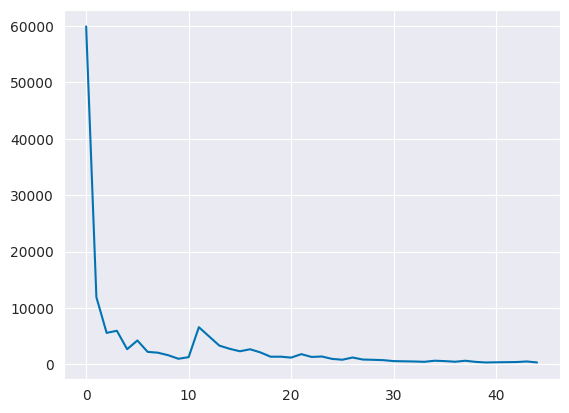

In [40]:
#plt.plot(val_loss, label   ='Validation loss')
plt.plot(train_loss, label='Training loss')

In [41]:
regression_model.eval()
total_test_loss = 0
yhat = []
y = []
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = regression_model(images)
        yhat.append(outputs.squeeze().cpu().numpy().tolist())
        y.append(targets.cpu().numpy().tolist())
        loss = criterion(outputs.squeeze(), targets.float())  
        total_test_loss += loss.item()

avg_test_loss = np.sqrt(total_test_loss / len(test_loader))
print(f"Test RMSE: {avg_test_loss}")

y = np.array(y, dtype=object)
yhat = np.array(yhat , dtype=object)
y = np.concatenate(y)
#yhat = np.concatenate(yhat)

/home/luiz_facury/miniconda3/envs/whisper/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE: 21.56685688118796


In [42]:
df = pd.DataFrame(columns=['yhat', 'y'])
df['yhat'] = yhat
df['y'] = y
df.sort_values(by=['y'], inplace=True)

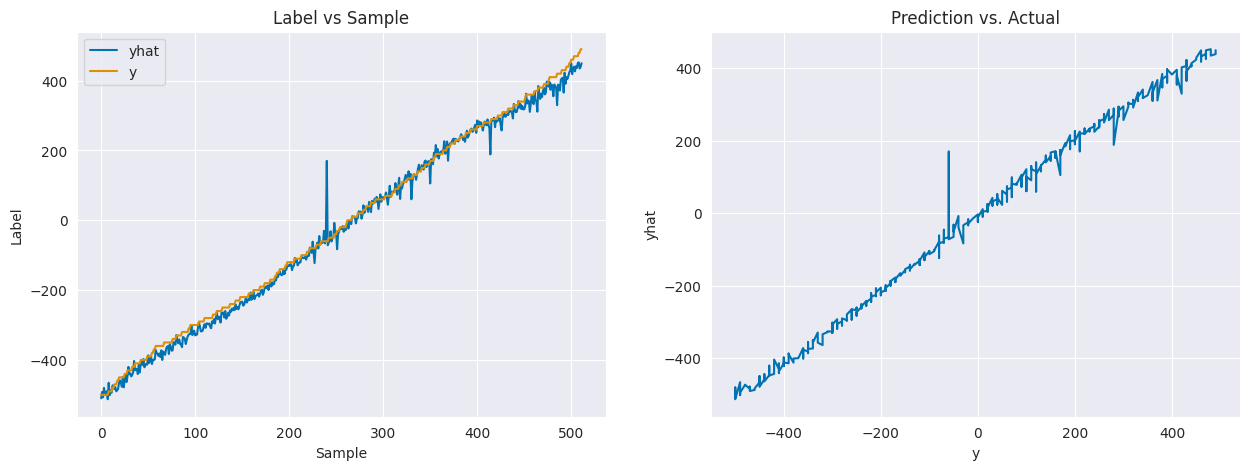

In [43]:
#create suplot with 2 columns and 1 row
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(df['yhat'].values)
ax[0].plot(df['y'].values)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Label')
ax[0].legend(['yhat', 'y'])
ax[0].set_title('Label vs Sample')

ax[1].plot(df['y'].values, df['yhat'].values)
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Prediction vs. Actual')

plt.show()

In [44]:
df

yhat      y
163 -509.976105 -500.0
342  -491.85556 -500.0
32   -507.10318 -500.0
469 -480.249756 -500.0
241 -497.752106 -500.0
..          ...    ...
156  449.672577  470.0
274  452.560516  480.0
508  434.911774  480.0
446  439.142548  490.0
478  449.827972  490.0

[512 rows x 2 columns]

# Test with the new video data

In [45]:
del train_loader
del test_loader
torch.cuda.empty_cache()

In [46]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data2')):
    for filename in tqdm(sorted(filenames, key=lambda x: int(re.sub('\D', '', x)))):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data)/255

100%|██████████| 442/442 [00:00<00:00, 4867.43it/s]


In [47]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
data_t = np.transpose(padded_data, (0, 3, 1, 2))
data_t = torch.from_numpy(data_t).to(device)

In [48]:
dl = DataLoader(data_t, batch_size=40, shuffle=False)

In [49]:
yhats = []
imgs = []
for i in dl:
    yhat = regression_model (i)
    imgs.append(i.detach().cpu().numpy())
    yhats.append(yhat.detach().cpu().numpy())
    del yhat
    torch.cuda.empty_cache()

In [50]:
yhats = np.concatenate(yhats)
imgs = np.concatenate(imgs)

In [51]:
imgs = np.transpose(imgs, (0,2,3,1))

/tmp/ipykernel_18075/1078603152.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[i]))


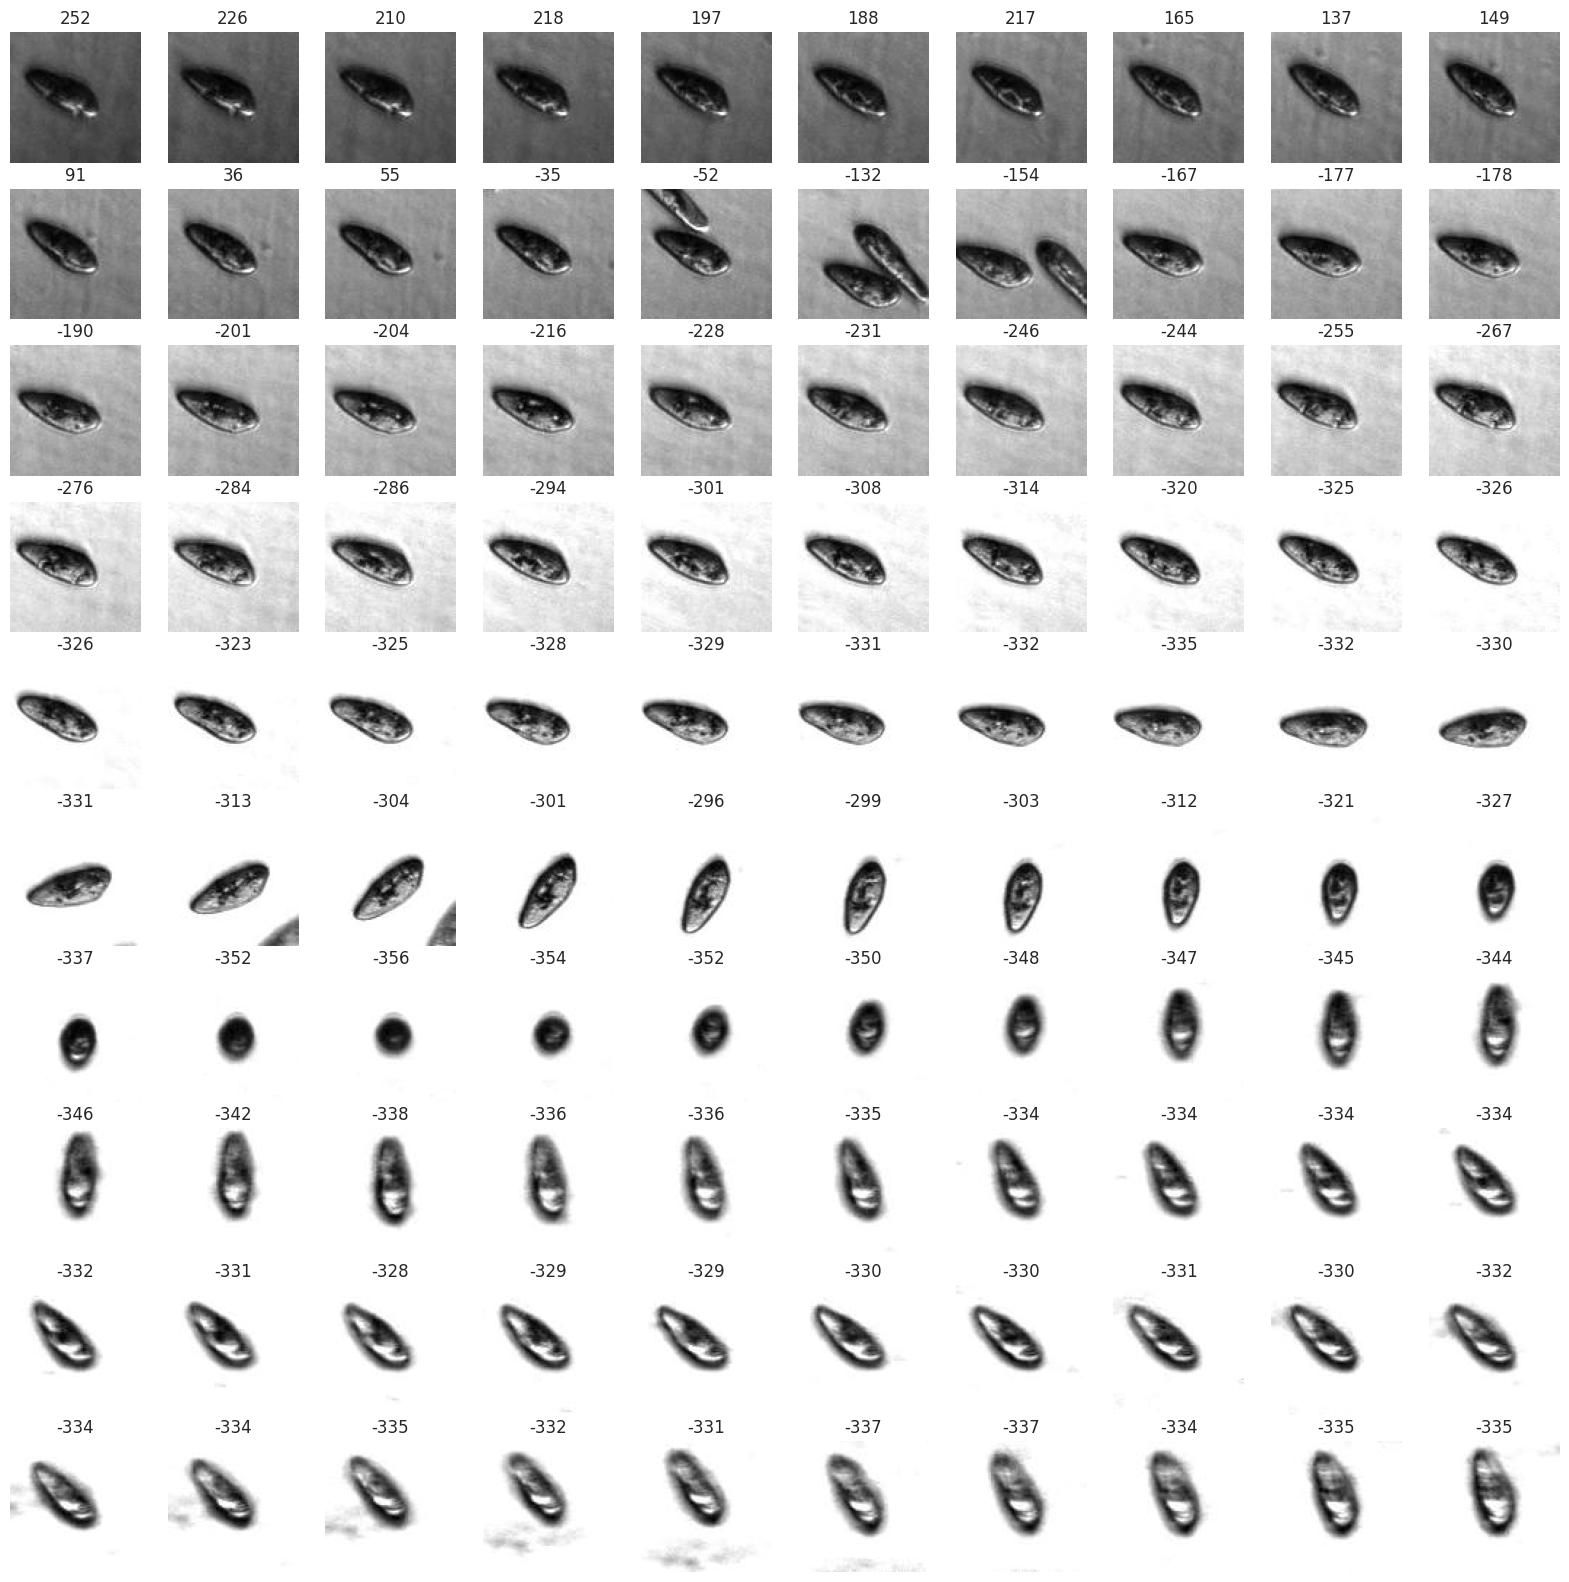

In [52]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax[i//10, i%10].imshow(imgs[i, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[i]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_18075/1689807850.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


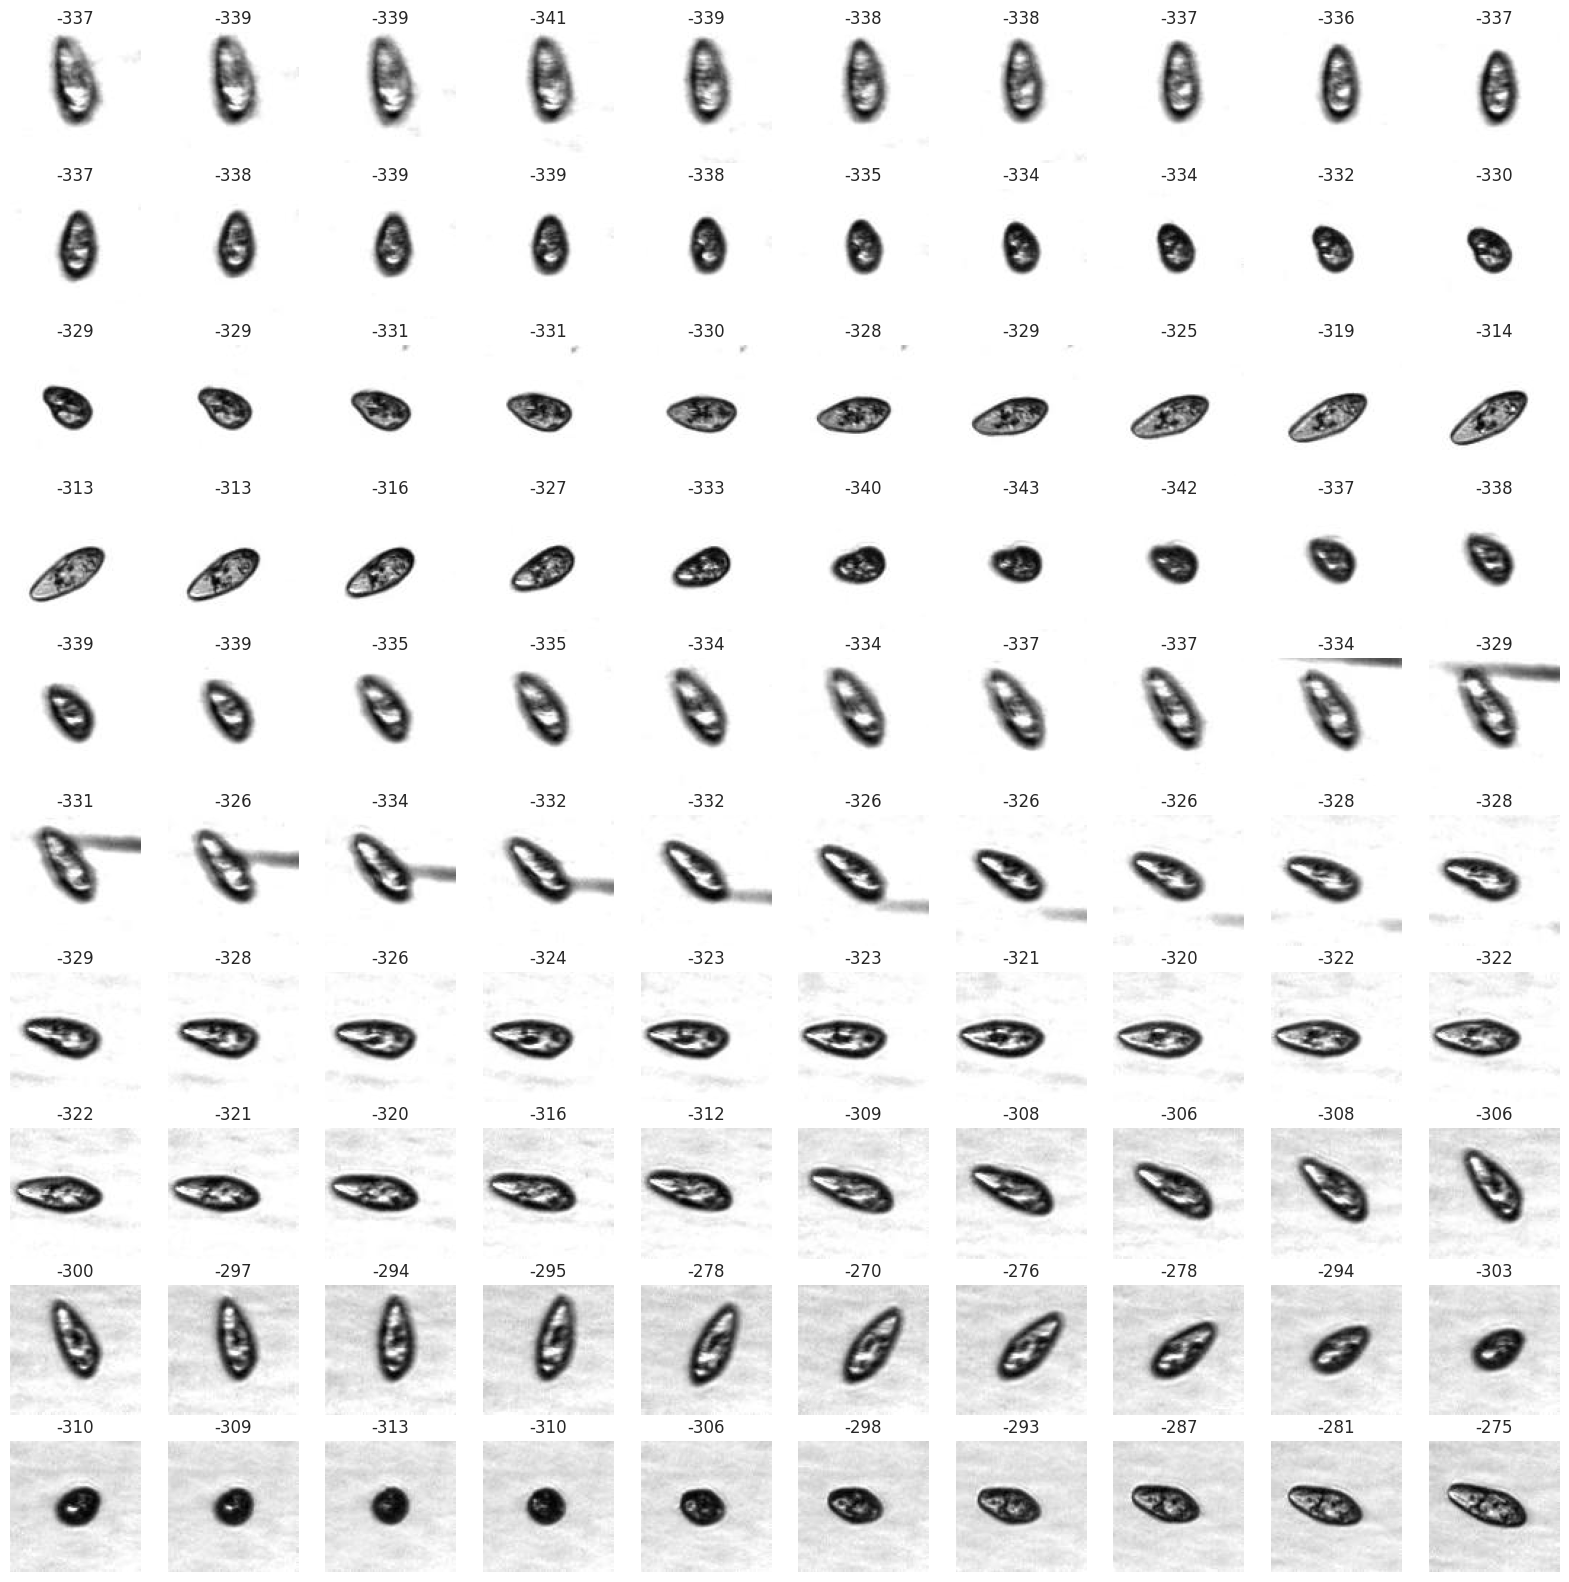

In [53]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(100, 200)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_18075/1970056730.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


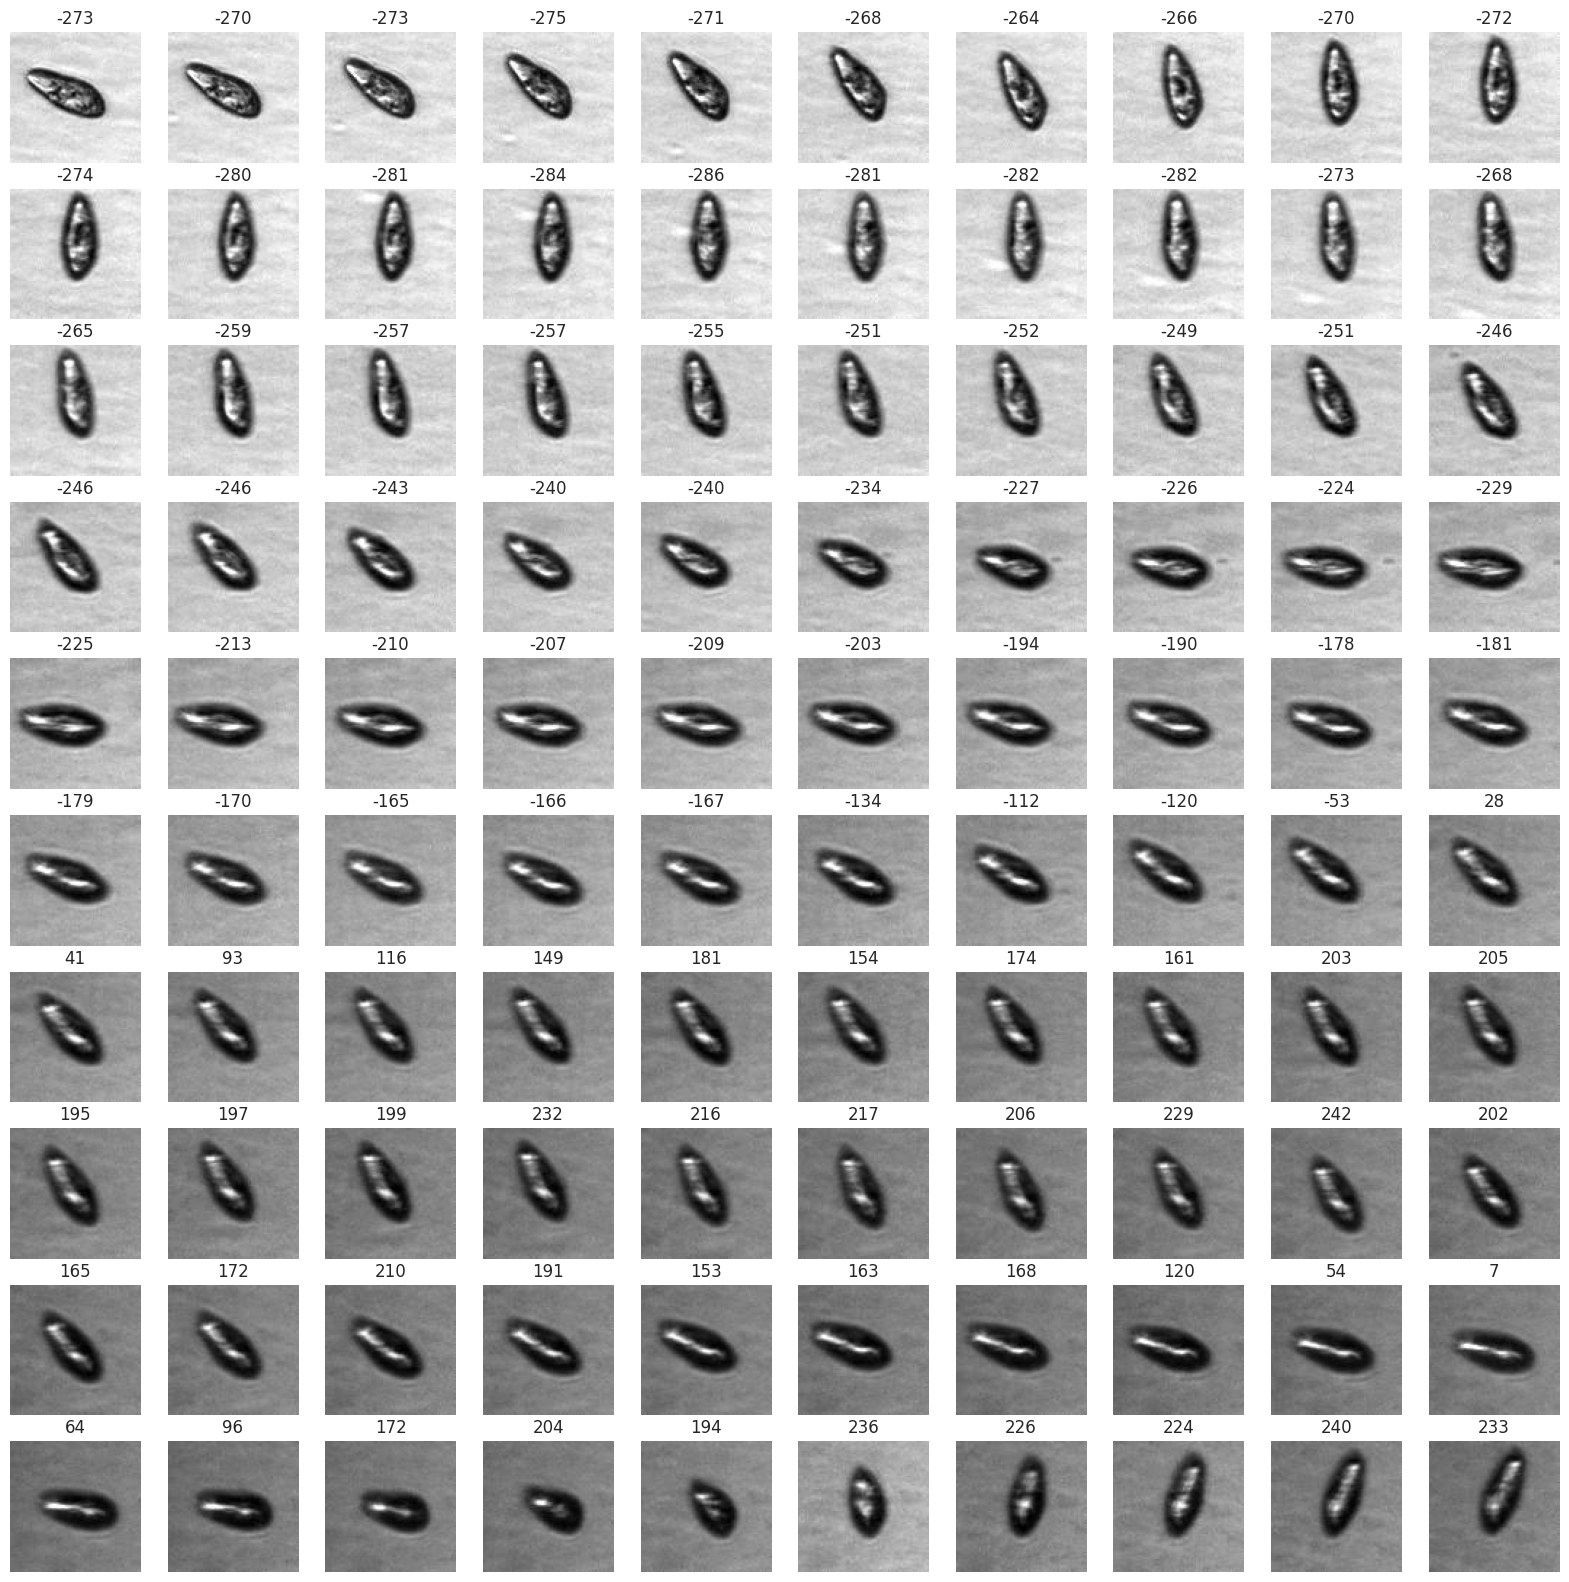

In [54]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(200, 300)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_18075/3319862177.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


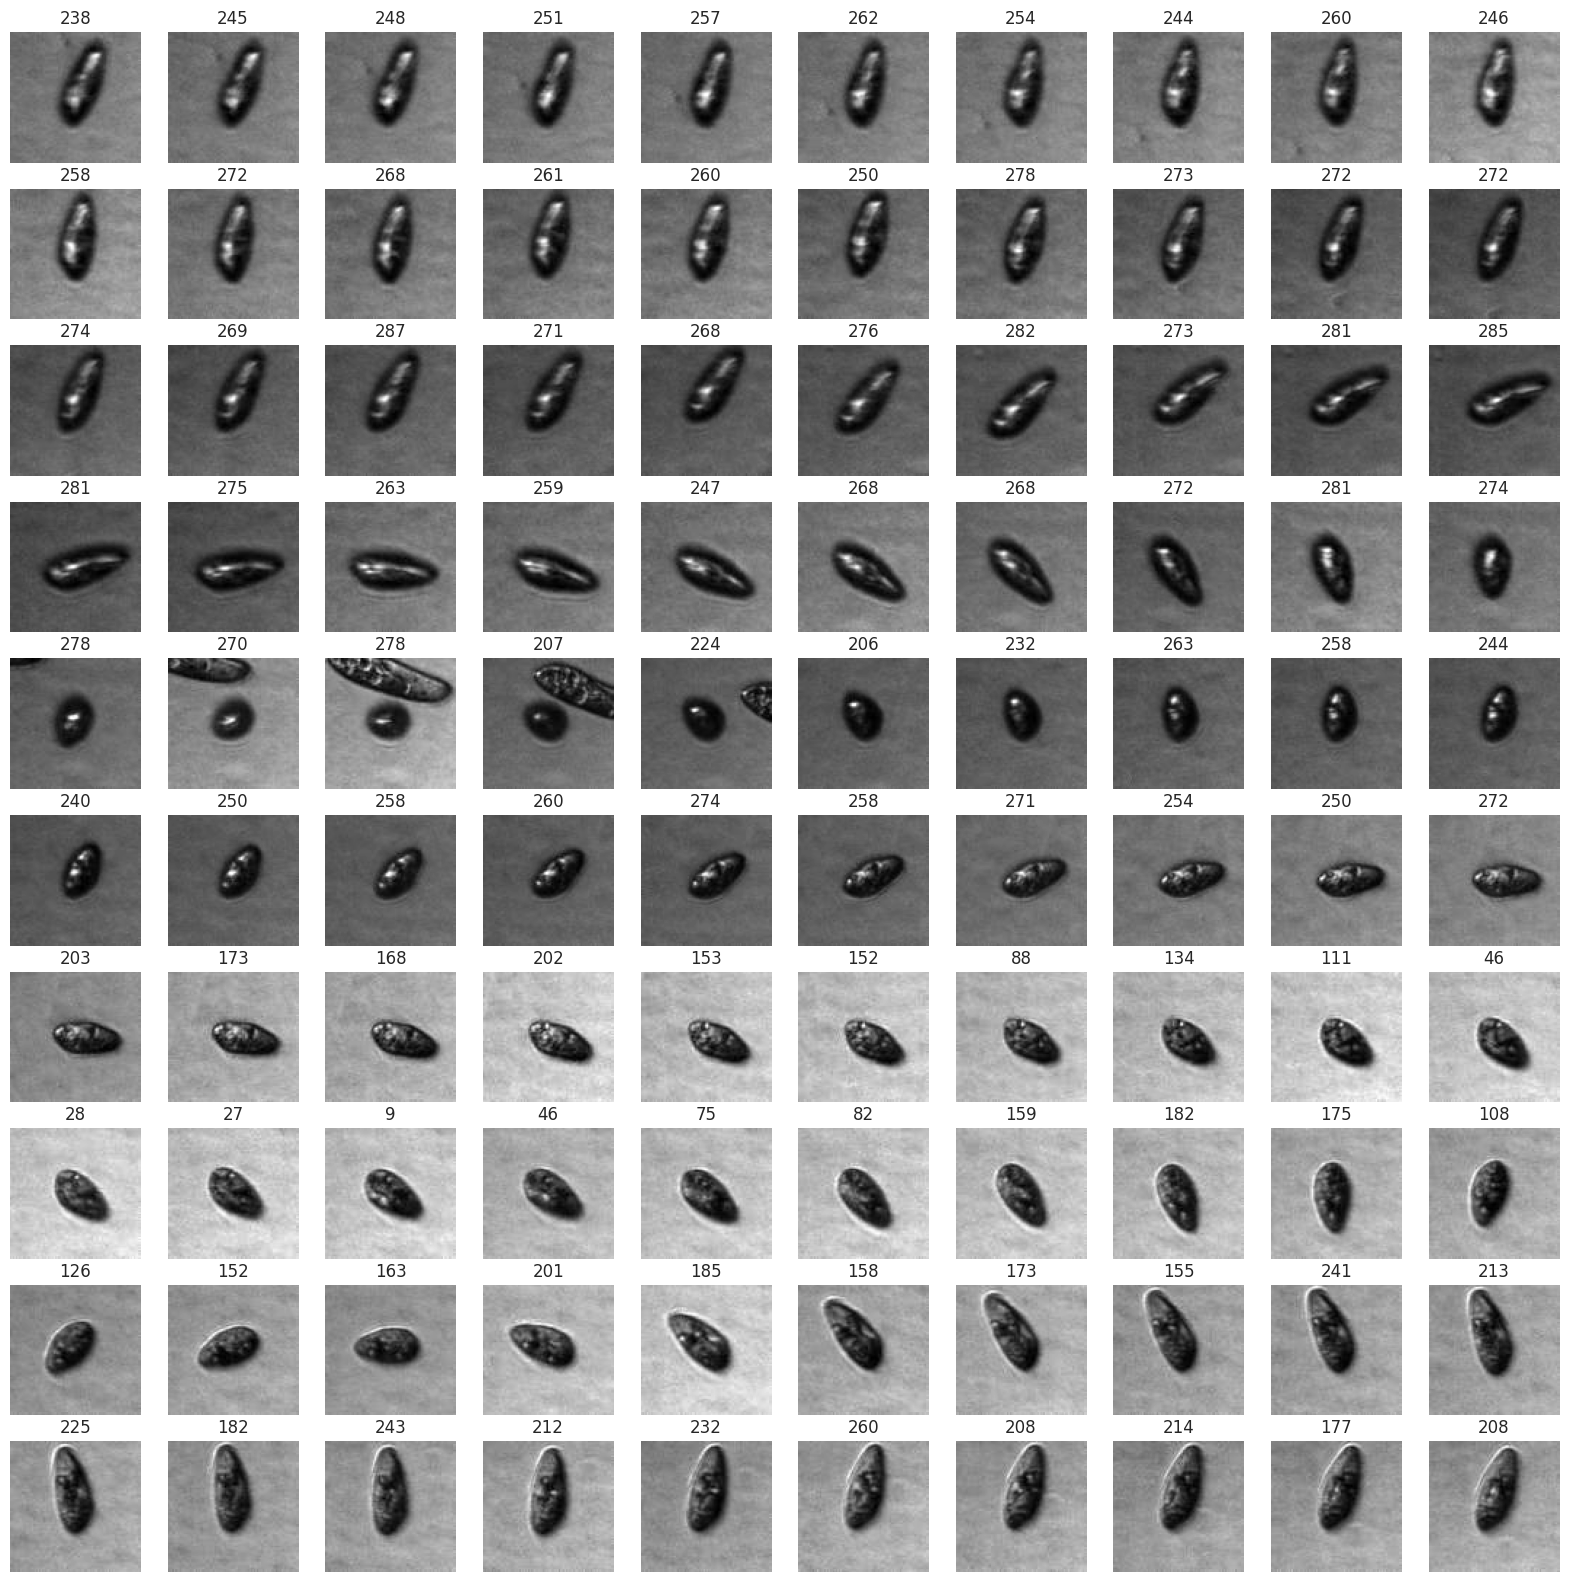

In [55]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(300, 400)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')

/tmp/ipykernel_18075/2565816389.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i//10, i%10].set_title(int(yhats[j]))


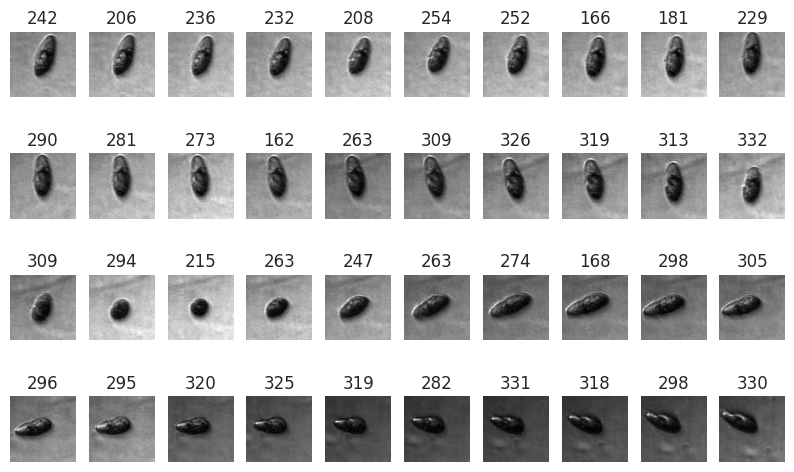

In [56]:
fig, ax = plt.subplots(4, 10, figsize=(10, 10))
for i,j in enumerate(range(400, 440)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(int(yhats[j]))
    ax[i//10, i%10].axis('off')
    #decrease distance betweeen subplots
    plt.subplots_adjust( hspace=-0.7)

In [57]:
#Save yhats to txt
np.savetxt("yhat.txt", yhats, fmt="%s")

In [58]:
r = np.arange(0, len(yhats)/20, 1/20)

In [59]:
r.shape

(442,)

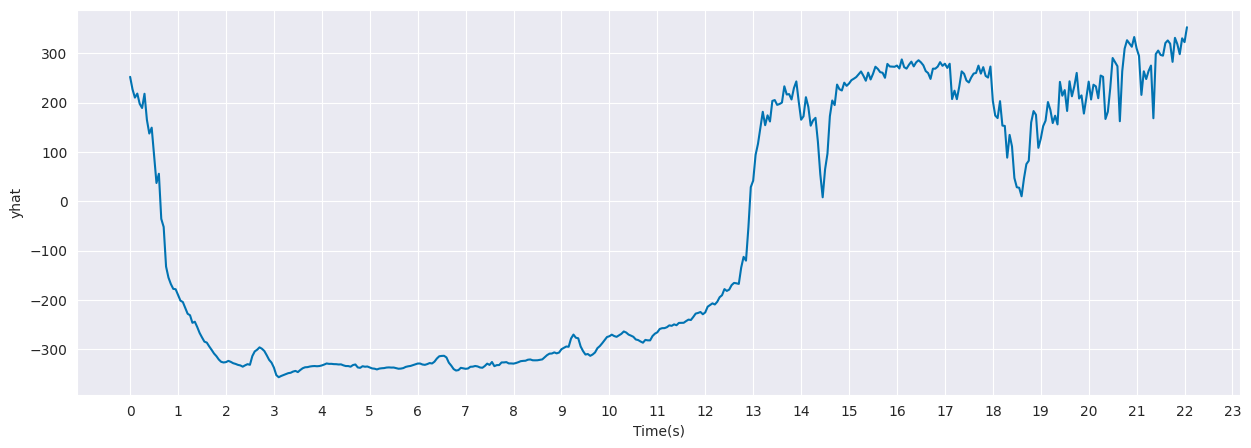

In [60]:
plt.figure(figsize=(15, 5))
plt.plot (r, yhats)
plt.ylabel('yhat')
plt.xlabel('Time(s)')
#make the x scale more precise
plt.xticks(np.arange(min(r), max(r)+1, 1))
plt.show()